In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch
import torch.nn as nn

import utils, archimedean, extreme, importlib
import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

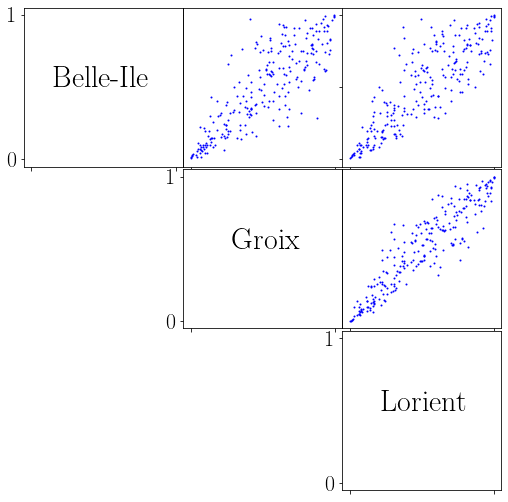

<Figure size 432x288 with 0 Axes>

In [2]:
nsamples = 240 # monthly maxima
ndims = 3

path = './data/synthetic/CNSD_C_1_14.p'
U0 = utils.load_data_0(path).float();
 
labels = ["Belle-Ile", "Groix", "Lorient"]
utils.plot_U(U0, labels=labels)

stdf = extreme.stdfNSD(alpha = torch.tensor([1.,2.,3.]), rho = torch.tensor([-0.69]))

In [3]:
class Generator(nn.Module):
    def __init__(self, ndims):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ndims, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, ndims),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)
    
class Discriminator(nn.Module):
    def __init__(self, ndims):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ndims, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)

In [4]:
netG = Generator(ndims).float()
netD = Discriminator(ndims).float()
criterion = nn.BCELoss()

real_label = 1.0;
fake_label = 0.0
n_batch = 200
n_iter = 5000
lr=1e-3

real_labels = torch.full((n_batch,),real_label)
fake_labels = torch.full((n_batch,),fake_label)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

time_array = np.zeros(int(n_iter/100))
iter_array = np.zeros(int(n_iter/100))
time_taken = 0

errD_real_array = np.zeros(n_iter)
errD_fake_array = np.zeros(n_iter)
errG_array = np.zeros(n_iter)

    
for iter_stdf in range(n_iter):
    
    data = U0[np.random.randint(0,nsamples,n_batch),:].detach()
    
    time_start = time.time()
    ## train discriminator

    # train with real    
    netD.zero_grad()
    output = netD(data)
    errD_real = criterion(output, real_labels.detach())
    errD_real.backward()

    # train with fake
    noise = torch.rand(n_batch,ndims)
    fake = netG(noise)
    output = netD(fake.detach())
    errD_fake = criterion(output, fake_labels.detach())
    errD_fake.backward()
    errD = errD_real + errD_fake
    optimizerD.step()

    ## train generator

    netG.zero_grad()
    output = netD(fake)
    errG = criterion(output, real_labels.detach())
    errG.backward()
    optimizerG.step()

    time_end = time.time()
    time_taken += (time_end-time_start)

    errD_real_array[iter_stdf] = errD_real.item()
    errD_fake_array[iter_stdf] = errD_fake.item()
    errG_array[iter_stdf] = errG.item()

    if iter_stdf % 100 == 0:

        time_array[int(iter_stdf/100)] = time_taken
        iter_array[int(iter_stdf/100)] = iter_stdf
        print(iter_stdf, time_taken, errD_real.item(), errD_fake.item(), errG.item())

0 0.15645909309387207 0.7518395781517029 0.6533886790275574 0.7486816644668579
100 1.1611404418945312 0.6956781148910522 0.6588930487632751 0.735138475894928
200 2.1864583492279053 0.6804757118225098 0.6467239260673523 0.7546947002410889
300 3.2123422622680664 0.6699472665786743 0.6609870195388794 0.7444251775741577
400 4.2059996128082275 0.6747295260429382 0.6957927942276001 0.7052580118179321
500 5.180393934249878 0.6094099879264832 0.5663833618164062 0.8647973537445068
600 6.176421642303467 0.6222370266914368 0.6277490854263306 0.8011109232902527
700 7.1830127239227295 0.6323263049125671 0.6350348591804504 0.8022242784500122
800 8.195210218429565 0.6621296405792236 0.682120144367218 0.739027202129364
900 9.18196177482605 0.7002805471420288 0.6653456091880798 0.7580764889717102
1000 10.219338655471802 0.5650741457939148 0.5531584620475769 0.927842378616333
1100 11.320516109466553 0.6372968554496765 0.6961385607719421 0.7426602840423584
1200 12.296096324920654 0.6023008823394775 0.639

In [5]:
# block maximas and compute IRAE

IRAEloss_array = np.zeros(10)
for n in range(10):
    noise = torch.rand(200000,ndims)
    fake = netG(noise)

    Uev = fake.view(100,2000,ndims).max(dim=0)[0].detach().numpy()
    for i in range(ndims):
        Uev[:, i] = scipy.stats.rankdata(Uev[:, i], 'ordinal')/2000
    #utils.plot_stdf3(extreme.stdfCFG(torch.tensor(Uev)))

    U_test = utils.rand_simplex(10000,ndims)

    stdfmax = extreme.stdfCFG(torch.tensor(Uev))(U_test)
    stdfGT = stdf(U_test)
    IRAEloss_array[n] = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
    print(IRAEloss_array[n])
print(IRAEloss_array.mean(),IRAEloss_array.std())

0.22732600569725037
0.23779185116291046
0.246735081076622
0.2430812567472458
0.2312898486852646
0.23709140717983246
0.22686581313610077
0.22712929546833038
0.21046005189418793
0.2355060577392578
0.23232766687870027 0.009731429272493815


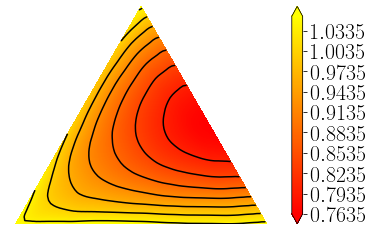

In [6]:
utils.plot_stdf3(extreme.stdfCFG(torch.tensor(Uev)))